<br>

# Semantic Segmentation with U-Net++
---
<br>

<br>

## 데이터셋 준비 <br><br>

[KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)

<br>

In [ ]:
!mkdir semantic_segmentation

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip -p /content/semantic_segmentation/data/

In [ ]:
!unzip /content/semantic_segmentation/data/data_semantics.zip

<br><br>

## data loader 만들기 <br><br>

(224,224) 크기의 입력값과 (224,224) 크기의 출력값을 갖는 <br>
모델 학습을 위한 위한 데이터셋을 생성해야 합니다. <br><br>

원본 데이터로부터 이러한 데이터셋을 생성하는 data loader 함수를 작성하고, <br>
해당 함수에 augmentation 을 적용해 보겠습니다. <br><br>

학습셋 일부를 검증셋 (validation dataset) 으로 활용하도록 함수 작성

<br>

In [1]:
#필요한 라이브러리를 로드

import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import l2

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

<br>

### 데이터 전처리 : Augmentation <br><br>

이미지 어그멘테이션을 위한 라이브러리 albumentations 를 사용

In [2]:
# albumentations 라이브러리로 데이터 어그멘테이션 적용하는 함수 작성

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

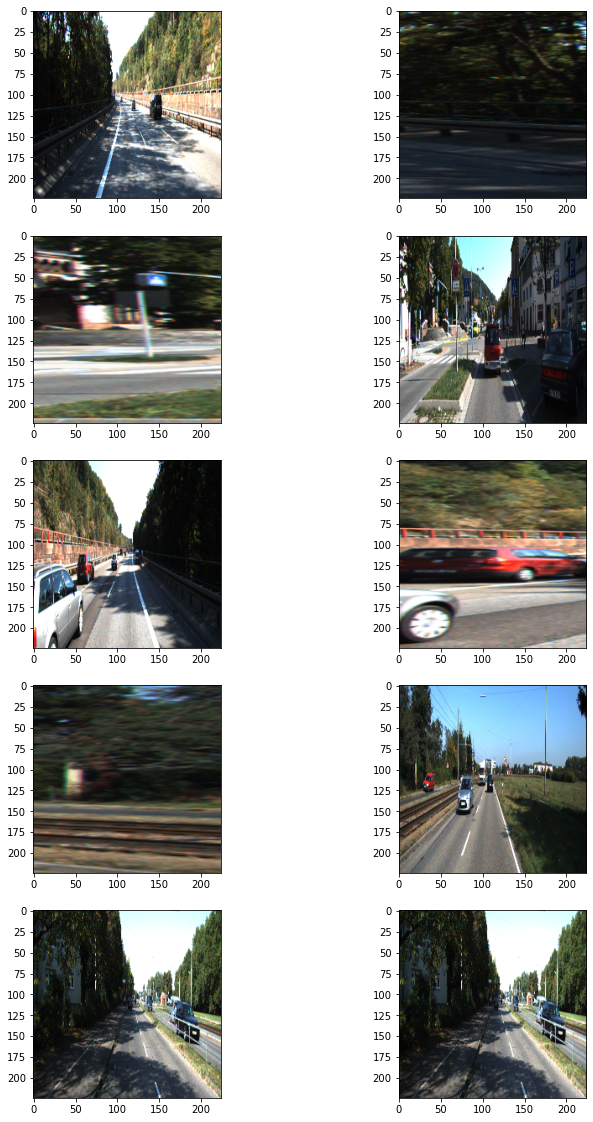

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

<br>

### data loader 클래스 작성 <br><br>

tf.keras.utils.Sequence 를 상속받는 generator 형태로 클래스 작성

<br>

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
# 데이터에 어그멘테이션 전처리를 적용 후,
# data loader 클래스로 학습을 위한 데이터셋 생성

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=test_preproc,
    is_train=False
)

<br>

## 모델 구조 : U-Net <br><br>

이미지 세그멘테이션을 위한 U-Net 모델 구성 <br><br>

- 입력이미지 : 위에서 작성한 data loader 와 맞추기 <br>

- 필요한 레이어와 연산 : Conv2D, UpSampling2D, MaxPooling2D, concatenate <br>
  ( 필요에 따라 Dropout 등 다른 레이어 적용 )

<br>

In [6]:
# U-Net 모델 구성

def build_model_unet(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

    #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [7]:
# U-Net 모델 컴파일 후 확인

model_unet = build_model_unet()
model_unet.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
# U-Net 모델 저장용 경로

model_unet_path = dir_path + '/seg_model_unet.h5'

In [ ]:
# U-Net 모델 학습

model_unet.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

In [ ]:
# 학습된 U-Net 모델 저장

model_unet.save(model_unet_path)  # 학습한 모델 저장

<br>

## 모델 구조 : U-Net++ <br><br>

이미지 세그멘테이션을 위한 U-Net++ 모델 구성 <br><br>

- 입력이미지 : 위에서 작성한 data loader 와 맞추기 <br>

- 필요한 레이어와 연산 : Conv2D, UpSampling2D, MaxPooling2D, concatenate <br>
  ( 필요에 따라 Dropout 등 다른 레이어 적용 )

<br>

In [9]:
# U-Net++ 모델 구성

def build_model_unetpp(input_shape=(224, 224, 3), deep_supervision=False):

  inputs = Input(input_shape)

  # X_0,0 convolution
  conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  # conv1_1 = Dropout(0.5)(conv1_1)
  conv1_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_1)
  conv1_1 = Dropout(0.5)(conv1_1)
  pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_1)

  # X_1,0 convolution
  conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  # conv2_1 = Dropout(0.5)(conv2_1)
  conv2_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_1)
  conv2_1 = Dropout(0.5)(conv2_1)
  pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_1)

  # X_0,1 convolution
  up1_2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_1)
  merge1_2 = concatenate([up1_2, conv1_1], axis=3)
  conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_2)
  # conv1_2 = Dropout(0.5)(conv1_2)
  conv1_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_2)
  conv1_2 = Dropout(0.5)(conv1_2)

  # X_2,0 convolution
  conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  # conv3_1 = Dropout(0.5)(conv3_1)
  conv3_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_1)
  conv3_1 = Dropout(0.5)(conv3_1)
  pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_1)

  # X_1,1 convolution
  up2_2 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_1)
  merge2_2 = concatenate([up2_2, conv2_1], axis=3)
  conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_2)
  # conv2_2 = Dropout(0.5)(conv2_2)
  conv2_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_2)
  conv2_2 = Dropout(0.5)(conv2_2)

  # X_0,2 convolution
  up1_3 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_2)
  merge1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=3)
  conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_3)
  # conv1_3 = Dropout(0.5)(conv1_3)
  conv1_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_3)
  conv1_3 = Dropout(0.5)(conv1_3)

  # X_3,0 convolution
  conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  # conv4_1 = Dropout(0.5)(conv4_1)
  conv4_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_1)
  conv4_1 = Dropout(0.5)(conv4_1)
  pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_1)

  # X_2,1 convolution
  up3_2 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_1)
  merge3_2 = concatenate([up3_2, conv3_1], axis=3)
  conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_2)
  # conv3_2 = Dropout(0.5)(conv3_2)
  conv3_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_2)
  conv3_2 = Dropout(0.5)(conv3_2)

  # X_1,2 convolution
  up2_3 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_2)
  merge2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=3)
  conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_3)
  # conv2_3 = Dropout(0.5)(conv2_3)
  conv2_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_3)
  conv2_3 = Dropout(0.5)(conv2_3)

  # X_0,3 convolution
  up1_4 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_3)
  merge1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=3)
  conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_4)
  # conv1_4 = Dropout(0.5)(conv1_4)
  conv1_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_4)
  conv1_4 = Dropout(0.5)(conv1_4)

  # X_4,0 convolution
  conv5_1 = Conv2D(1028, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)
  # conv5_1 = Dropout(0.5)(conv5_1)
  conv5_1 = Conv2D(1028, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5_1)
  conv5_1 = Dropout(0.5)(conv5_1)
  pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_1)

  # X_3,1 convolution
  up4_2 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5_1)
  merge4_2 = concatenate([up4_2, conv4_1], axis=3)
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4_2)
  # conv4_2 = Dropout(0.5)(conv4_2)
  conv4_2 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4_2)
  conv4_2 = Dropout(0.5)(conv4_2)

  # X_2,2 convolution
  up3_3 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4_2)
  merge3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=3)
  conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3_3)
  # conv3_3 = Dropout(0.5)(conv3_3)
  conv3_3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3_3)
  conv3_3 = Dropout(0.5)(conv3_3)

  # X_1,3 convolution
  up2_4 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3_3)
  merge2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=3)
  conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2_4)
  # conv2_4 = Dropout(0.5)(conv2_4)
  conv2_4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2_4)
  conv2_4 = Dropout(0.5)(conv2_4)

  # X_0,4 convolution
  up1_5 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2_4)
  merge1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=3)
  conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1_5)
  # conv1_5 = Dropout(0.5)(conv1_5)
  conv1_5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1_5)
  conv1_5 = Dropout(0.5)(conv1_5)
  

  nestnet_output_1 = Conv2D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
  nestnet_output_2 = Conv2D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
  nestnet_output_3 = Conv2D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
  nestnet_output_4 = Conv2D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

  if deep_supervision:
      model = Model(inputs=inputs, outputs=[nestnet_output_1, nestnet_output_2, nestnet_output_3, nestnet_output_4])
  else:
      model = Model(inputs=inputs, outputs=[nestnet_output_4])

  return model


In [10]:
# U-Net++ 모델 컴파일 후 확인

model_unetpp = build_model_unetpp()
model_unetpp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')

model_unetpp.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 224, 224, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [11]:
# U-Net++ 모델 저장용 경로

model_unet_pathpp = dir_path + '/seg_model_unetpp.h5'

In [ ]:
# U-Net++ 모델 학습

model_unetpp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

In [ ]:
# 학습된 U-Net++ 모델 저장

model_unetpp.save(model_unet_pathpp)  # 학습한 모델 저장

<br>

## 모델 결과 : 정성적 평가, 정량적 평가 <br><br>

### 정성적 평가 : 결과 이미지 시각화 <br><br>

semantic segmentation 테스크를 학습한 U-Net 모델이 추론(inference)한 결과를 <br>
시각적으로 확인 가능한 세그멘테이션 이미지로 만들어 확인 <br><br>

입력 이미지와 라벨을 한번에 볼 수 있도록, <br>
모델 출력값을 입력 이미지 위에 겹쳐 보이기 (overray) <br><br>

-> PIL 패키지의 Image.blend 활용 <br><br>


### 정량적 평가 : 결과값 IoU 계산 <br><br>

IoU (Intersection over Union) : 이미지 세그멘테이션의 성능을 정량적으로 측정하기 위한 방법 <br><br>

모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, <br>
그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요 <br>
각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현


<br>

In [12]:
tf.__version__

'2.4.1'

In [14]:
# 위에서 학습하여 저장한 모델 로드하여 사용 가능

model_unet = tf.keras.models.load_model(model_unet_path)
model_unetpp = tf.keras.models.load_model(model_unet_pathpp)

In [15]:
# IoU 계산하는 함수 작성

def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [16]:
# 세그멘테이션 결과 이미지 출력하는 함수 작성

def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

<br>

## 결과 확인

<br>

In [17]:
# 테스트 결과 확인할 테스트 이미지 인덱스 설정

i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다.

IoU : 0.790946


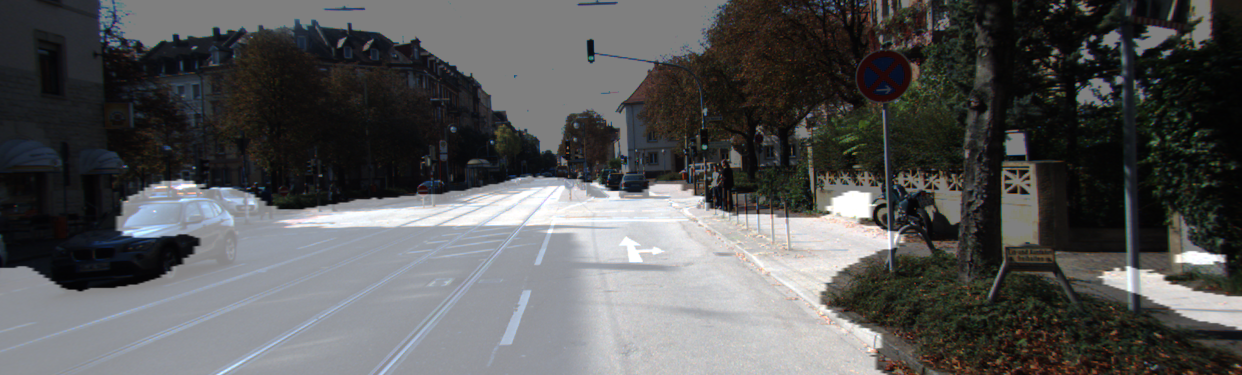

In [18]:
# 시각화한 결과 확인 

output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

# IoU 확인
calculate_iou_score(target, prediction)
# 시각화 결과 확인
output

IoU : 0.636533


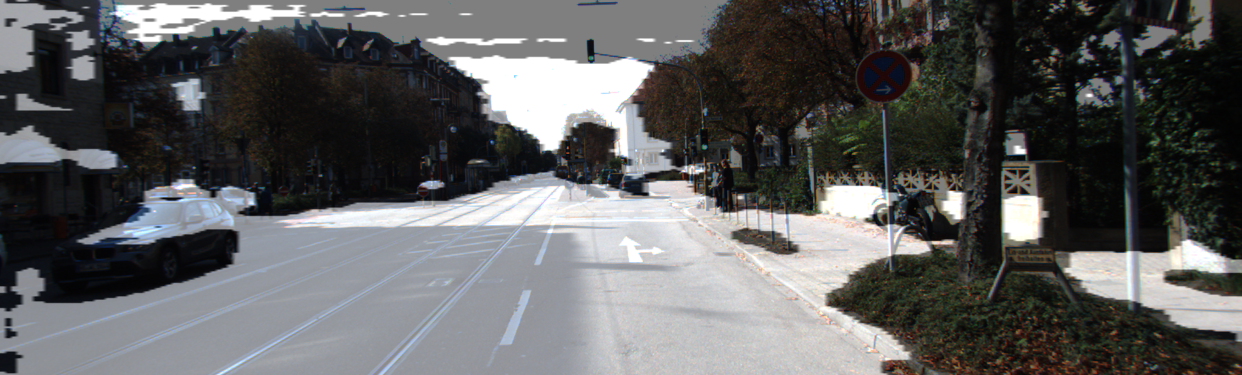

In [19]:
# 시각화한 결과 확인

output, prediction, target = get_output(
     model_unetpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

# IoU 확인
calculate_iou_score(target, prediction)
# 시각화 결과 확인
output

<br>

## 결과 분석 <br><br>

### 학습시간 및 파라미터 개수 <br><br>

U-Net 과 U-Net++ 모두 학습시간과 파라미터 개수가 비슷하였습니다. <br><br><br>


### IoU 결과 <br><br>

사진에 따라 더 우세한 쪽이 다른 경우가 있었지만, <br>
대체로 U-Net 이 U-Net++ 보다 IoU 계산 결과가 약 0.02 좋게 나왔습니다. <br><br>

1. U-Net <br><br>

  01번째 사진 IoU : 0.865405 <br>
  10번째 사진 IoU : 0.793819 <br>
  20번째 사진 IoU : 0.793850 <br>
  30번째 사진 IoU : 0.774826 <br>
  40번째 사진 IoU : 0.924838 <br>
  50번째 사진 IoU : 0.826398 <br><br>

2. U-Net++ <br><br>
  
  01번째 사진 IoU : 0.800210 <br>
  10번째 사진 IoU : 0.763780 <br>
  20번째 사진 IoU : 0.783600 <br>
  30번째 사진 IoU : 0.790518 <br>
  40번째 사진 IoU : 0.807393 <br>
  50번째 사진 IoU : 0.807393

<br>